In [ ]:
import requests
import re
import os
import glob
import pandas as pd
import xarray as xr
import xesmf as xe
import zarr
# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')
# Verify the change
print("Current Working Directory:", os.getcwd())

#### List files that will be used to downsample the reference dataset (GMFD)

In [1]:
# Use a file pattern to load all precipitation files
#file_pr = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro/prcp_daily_ro_*.nc'
file_pr = '/data/keeling/a/ad87/gmfd/ncs/ro/prcp_daily_ro_*.nc'
# Open multiple files as a single dataset
pr = xr.open_mfdataset(file_pr, combine='by_coords')
# Rename variable from 'prcp' to 'pr' to be consistent with cmip6
pr = pr.rename({'prcp': 'pr'})


#file_ta = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro/tas_daily_ro_*.nc'
file_ta = '/data/keeling/a/ad87/gmfd/ncs/ro/tas_daily_ro_*.nc'
# Open multiple files as a single dataset
ta = xr.open_mfdataset(file_ta, combine='by_coords')
print(ta)


NameError: name 'xr' is not defined

#### CMIP6 raw data structure to be read

Iterate through each file that that should be used for resample the observational datset

In [3]:
# Define the base directory
#directory = "../../cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw"
directory = "/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw"

# Initialize an empty list to store matching files
matching_files = []

# Find all .zarr directories recursively in subdirectories
for root, dirs, files in os.walk(directory):
    for dir_name in dirs:
        if dir_name.endswith(".zarr") and "pr" in dir_name and "historical" in dir_name:
            matching_files.append(os.path.join(root, dir_name))

# Print the list of matching files (optional)
# print(matching_files)

In [4]:
for file in matching_files:
    print(f"\nReading Zarr file: {file}")
    # Extract the model name (e.g., 'IPSL-CM6A-LR') from the file path
    parts = file.split('/')
    model_name = parts[8]  # The model name is in the 8th part of the path (0-indexed)
    
    # Define the target directory path
    target_directory = os.path.join('zarr/gmfd_harm', model_name)
    
    # Create the directory if it doesn't exist
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
        print(f"Created directory: {target_directory}")
    else:
        print(f"Directory already exists: {target_directory}")
    # Open the Zarr file using xarray
    ds = xr.open_zarr(file, consolidated=False)  # Set consolidated=True if the dataset is consolidate
    # get lat and lon dimensions (could be applied to booth observational pr and tas
    target_lat = ds.lat
    target_lon = ds.lon
    # resample observational pr and tas
    resampled_pr = pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
    resampled_ta = ta.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
    # Create the filename and full path
    # Full path to save the Zarr file
    ta_full_path = os.path.join(target_directory,f"tas_{model_name}.zarr")
    pr_full_path = os.path.join(target_directory,f"pr_{model_name}.zarr")
    resampled_pr = resampled_pr.chunk({'time': 100, 'lat': 50, 'lon': 50})  # Example chunk sizes
    resampled_ta = resampled_ta.chunk({'time': 100, 'lat': 50, 'lon': 50})  # Example chunk sizes
    
    # Define the compressor
    compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=1)
    # Create an encoding dictionary for all data variables
    encoding_pr = {var: {'compressor': compressor} for var in resampled_pr.data_vars}
    encoding_ta = {var: {'compressor': compressor} for var in resampled_ta.data_vars}
    
    # Save the subset to Zarr with compression
    resampled_ta.to_zarr(ta_full_path, mode='w', encoding=encoding_ta)
    resampled_pr.to_zarr(pr_full_path, mode='w', encoding=encoding_pr)


Reading Zarr file: /data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/IPSL-CM6A-LR/historical/r1i1p1f1/pr/pr_day_IPSL-CM6A-LR_historical_r1i1p1f1_gr_1950_2014_rou.zarr
Created directory: zarr/gmfd_harm/IPSL-CM6A-LR

Reading Zarr file: /data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr
Created directory: zarr/gmfd_harm/CNRM-ESM2-1

Reading Zarr file: /data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/MPI-ESM1-2-LR/historical/r1i1p1f1/pr/pr_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gr_1950_2014_rou.zarr
Created directory: zarr/gmfd_harm/MPI-ESM1-2-LR

Reading Zarr file: /data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/MPI-ESM1-2-HR/historical/r1i1p1f1/pr/pr_day_MPI-ESM1-2-HR_historical_r1i1p1f1_gr_1950_2014_rou.zarr
Created directory: zarr/gmfd_harm/MPI-ESM1-2-HR

Reading Zarr file: /data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/MIROC6/historical/r1i1p1f1/pr/pr_day_MIROC6_historical_r1i1p1f1_gr_1950_2014_rou.zarr
Create

In [18]:
# Iterate through each matching file
for file in matching_files:
    print(f"\nReading Zarr file: {file}")
    
    # Open the Zarr file using xarray
    ds = xr.open_zarr(file, consolidated=False)  # Set consolidated=True if the dataset is consolidate
    # get lat and lon dimensions (could be applied to booth observational pr and tas
    target_lat = ds.lat
    target_lon = ds.lon
    # resample observational pr and tas
    resampled_pr = pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
    resampled_ta = ta.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})






Reading Zarr file: /data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/IPSL-CM6A-LR/historical/r1i1p1f1/pr/pr_day_IPSL-CM6A-LR_historical_r1i1p1f1_gr_1950_2014_rou.zarr
<xarray.Dataset> Size: 8MB
Dimensions:      (lat: 8, lon: 10, time: 23741, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float32 32B 41.83 43.1 44.37 45.63 46.9 48.17 49.44 50.7
  * lon          (lon) float32 40B 7.5 10.0 12.5 15.0 ... 22.5 25.0 27.5 30.0
  * time         (time) datetime64[ns] 190kB 1950-01-01T12:00:00 ... 2014-12-...
    time_bounds  (time, axis_nbounds) datetime64[ns] 380kB dask.array<chunksize=(23741, 1), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables:
    pr           (time, lat, lon) float32 8MB dask.array<chunksize=(100, 8, 10), meta=np.ndarray>
Attributes: (12/54)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  historical
    NCO:                    "4.6.0"
    activity_id:            CMIP
   

In [34]:
target_lat = ds.lat
target_lon = ds.lon
resampled_ds = pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

In [22]:
print(resampled_ds)

<xarray.Dataset> Size: 19MB
Dimensions:  (time: 23741, lat: 9, lon: 22)
Coordinates:
  * time     (time) datetime64[ns] 190kB 1950-01-01 1950-01-02 ... 2014-12-31
  * lat      (lat) float64 72B 42.06 43.18 44.3 45.42 ... 48.78 49.91 51.03
  * lon      (lon) float64 176B 6.75 7.875 9.0 10.12 ... 27.0 28.12 29.25 30.38
Data variables:
    prcp     (time, lat, lon) float32 19MB dask.array<chunksize=(365, 9, 22), meta=np.ndarray>


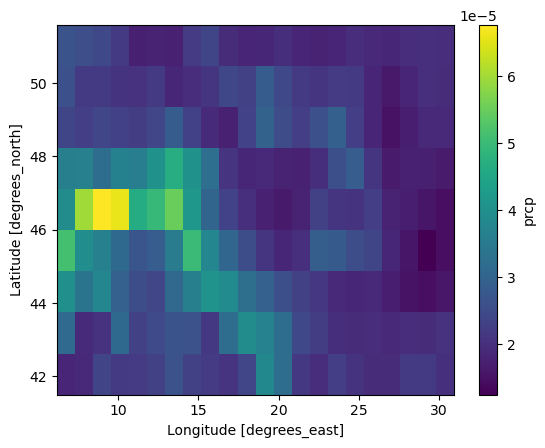

In [36]:
resampled_ds['prcp'].mean(dim='time').plot()

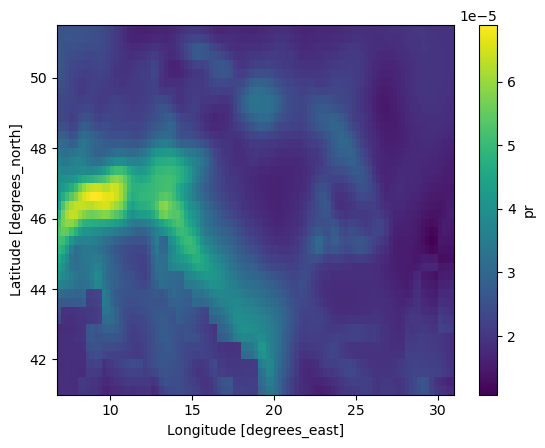

In [42]:
pr['pr'].mean(dim='time').plot()

In [30]:
print(ds)
print(ta)
print(resampled_ds)


<xarray.Dataset> Size: 19MB
Dimensions:    (lat: 9, bnds: 2, lon: 22, time: 23741)
Coordinates:
  * lat        (lat) float64 72B 42.06 43.18 44.3 45.42 ... 48.78 49.91 51.03
    lat_bnds   (lat, bnds) float64 144B dask.array<chunksize=(9, 2), meta=np.ndarray>
  * lon        (lon) float64 176B 6.75 7.875 9.0 10.12 ... 28.12 29.25 30.38
    lon_bnds   (lon, bnds) float64 352B dask.array<chunksize=(22, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 190kB 1950-01-01T12:00:00 ... 2014-12-31...
    time_bnds  (time, bnds) datetime64[ns] 380kB dask.array<chunksize=(23741, 1), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 19MB dask.array<chunksize=(100, 9, 22), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  164359.0
    cmor_version:           3.5.0
    ...  

In [ ]:
file = "../../cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr"
cmip6 = xr.open_zarr(file, consolidated=True)
# Assume 'pr' is the variable of interest
cmip6['pr'].mean(dim='time').plot()